# Fast Adaptive Broadening

Convolution is a common operation used for broadening spectral data, where a kernel (often either a Gaussian or Lorentzian) is used to broaden the data. Convolution with a fixed kernel can be carried out efficiently using Fast Fourier Transforms (FFTs). However, when simulating Inelastic Neutron Scattering (INS) spectra, the width of the Gaussian kernel used for broadening is variable, and therefore performing convolution by a fixed kernel is not appropriate. Instead, an adaptive broadening technique is required.

Adaptive broadening can be implemented exactly by computing a Gaussian kernel for each point along the input spectrum, where the standard deviation, $\sigma$, of each kernel is dependent on its associated input data point. The sum of the product of each kernel and its associated data point should then be calculated to give the broadened spectrum. Whilst this approach provides accurate results, the evaluation of N Gaussian Functions (where N is the number of convolution bins) is computationally expensive, leading to a poor user experience.

To reduce computation time, a faster, approximate method is required. This can be achieved by reducing the number of Gaussian functions that have to be evaluated. Taking the range of $\sigma$ values for the spectrum, a Gaussian function need only be evaluated for regularly spaced $\sigma$ values across this range. The kernels at intermediate $\sigma$ values can then be approximated using a weighted linear combination of the two closest kernels that have been calculated exactly. The weights for the linear combination can be determined, for example, using linear interpolation, where the weight $w = (\sigma - \sigma_{min})/(\sigma_{max} - \sigma_{min})$ can be used to approximate the Gaussian $G(x;\sigma) = (1-w)G(x;\sigma_{min}) + wG(x;\sigma_{max})$. For more detail on the linear combination weights and how they can be optimized, please see the [Approximating Gaussians](gaussian_approximation.ipynb) notebook.

The values of $\sigma$ for which the Gaussian function is evaluated exactly should be regularly spaced over the range of $\sigma$ values, with the spacing denoted as the width factor. With regular spacing, the relationship between the weights will be the same between each set of exact kernels. This relationship is determined by computing weights between a Gaussian with $\sigma=1$ and a Gaussian with $\sigma$ equal to the width factor. For instance, consider a width factor of 2 has been selected - the plot below shows the relationship between the weight, $w$, when it is determined using linear interpolation. A polynomial can then be fitted (in this case a 1st order polynomial as linear interpolation has been used), allowing weights to be determined for any $\sigma$ value in that range.

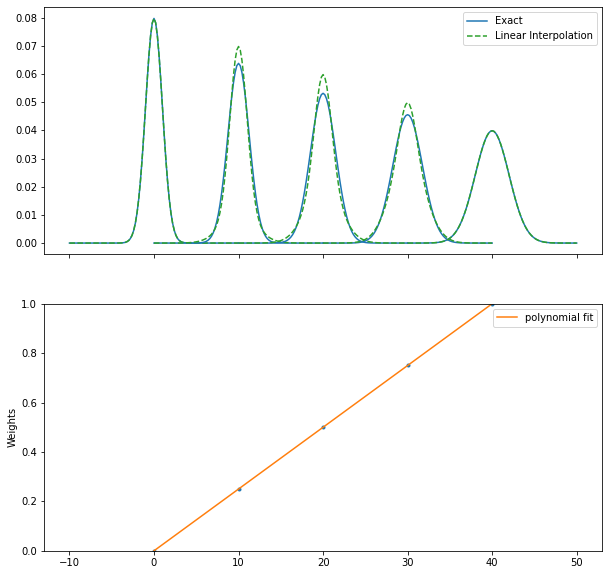

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g*0.2

def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))

def plot_linear_interp():
    """Plot linearly-interpolated Gaussians"""

    g1_center = 0
    g2_center = 40
    sigma_max = 2
    sigma_min = 1

    mix_list=[]

    x = np.linspace(-10, 10, 101)
    npts = 5

    fig, [ax1, ax2] = plt.subplots(nrows=2,
                                   sharex=True,
                                   gridspec_kw={
                                   'height_ratios': [1, 1]})

    for sigma in np.linspace(sigma_min, sigma_max, npts):
        x_offset = (g1_center
                  + ((sigma - sigma_min)
                     * (g2_center - g1_center) / (sigma_max - sigma_min)))
        actual = gaussian(x, sigma=sigma)
        low_ref = gaussian(x, sigma=sigma_min)
        high_ref = gaussian(x, sigma=sigma_max)
        mix = (sigma - sigma_min) / (sigma_max - sigma_min)
        est = (1 - mix) * low_ref + mix * high_ref
        ax1.plot(x + x_offset, actual, color='C0', label='Exact')
        ax1.plot(x + x_offset, est, c='C2', linestyle='--',  label='Linear Interpolation')
        legend_without_duplicate_labels(ax1)

        mix_list.append(mix)
    
    ax2.plot(np.linspace(g1_center, g2_center, npts), mix_list, '.')
    ax2.set_ylabel('Weights')
    ax2.set_ylim([0, 1])

    m, b = np.polyfit(np.linspace(g1_center, g2_center, npts), mix_list, 1)
    ax2.plot(np.linspace(g1_center, g2_center, npts), m*np.linspace(g1_center, g2_center, npts)+b,label='polynomial fit')
    ax2.legend()

plot_linear_interp()

Using the properties of convolution, these same weights can be used to scale the unbroadened spectrum, splitting the data into $\sigma_{min}$ and $\sigma_{max}$ contributions which can then be convolved using the $\sigma_{min}$ and $\sigma_{max}$ kernels respectively. The two broadened spectra can then be added together and this is equivalent to convolving the unbroadened spectrum with the linear combination of the two Gaussian functions, as shown below. 

$$
\begin{align}
f*((1-w)G_1 + w G_2) &= \int^{\infty}_{-\infty} f(\tau)((1-w)G_1(t-\tau)) + f(\tau)(w G_2(t-\tau)) \delta\tau \\
                    &=  \int^{\infty}_{-\infty} ((1-w)f(\tau)) G_1(t-\tau) \delta\tau + \int^{\infty}_{-\infty} (w f(\tau))G_2(t-\tau) \delta\tau\\
                    &= ((1-w)f)*G_1 + (wf)*G_2
\end{align}
$$

With this approach, each convolution has a fixed width kernel, therefore it can be performed efficiently using FFTs (which reduces complexity from $O(N^2)$ to $O(NlogN)$). These steps are illustrated below:

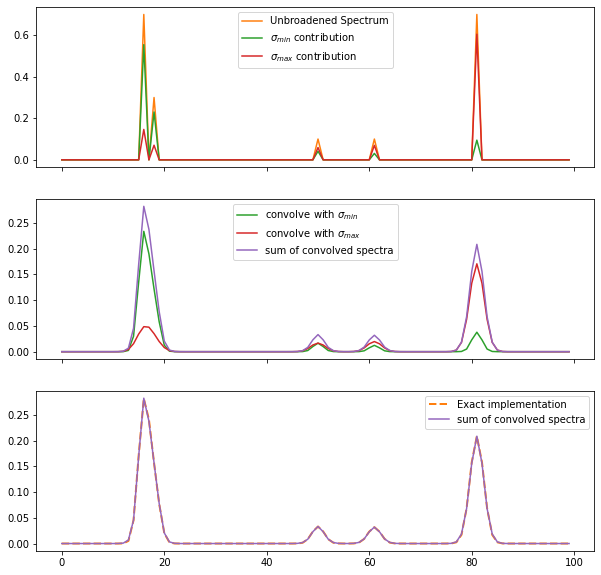

In [13]:
from scipy.signal import convolve

npts = 100
y = np.zeros(npts)

y[16] = 0.7
y[18] = 0.3
y[50] = 0.1
y[61] = 0.1
y[81] = 0.7

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3,
                                    sharex=True,
                                    gridspec_kw={
                                    'height_ratios': [1, 1, 1]})

ax1.plot(range(0,npts), y, 'C1', label='Unbroadened Spectrum')

bins = np.linspace(0,100,101)
bin_mp = (bins[1:]+bins[:-1])/2
frequencies = bin_mp

sigma = np.linspace(1, np.sqrt(2), 100)

def gaussian_eval(sigma, points, center):
    # calculate bin width, which is then used to normalize the Gaussian
    b_width = points[1] - points[0] 
    kernel = np.exp(-(points - center)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))*b_width
    return kernel

# reference method
kernels = gaussian_eval(sigma[:,np.newaxis], bin_mp, frequencies[:,np.newaxis])
result_gauss = np.dot(kernels.transpose(), y)

bin_width = bins[1]-bins[0]

# fast method
sigma_samples = np.array([1,np.sqrt(2)])
kernels = gaussian_eval(sigma=sigma_samples[:, np.newaxis],
                        points=np.arange(-6, 7, 1)*bin_width, center=0)
lower_mix = np.polyval([-0.6079, 4.101, -9.632, 7.139], sigma)
upper_mix = np.polyval([0.7533, -4.882, 10.87, -6.746], sigma)

lower_scaled = lower_mix*y
ax1.plot(lower_scaled, 'C2', label='$\sigma_{min}$ contribution')

upper_scaled = upper_mix*y
ax1.plot(upper_scaled, 'C3', label='$\sigma_{max}$ contribution')
ax1.legend()

lower_convolve = convolve(lower_scaled, kernels[0], mode="same")
upper_convolve = convolve(upper_scaled, kernels[1], mode="same")

spectrum = lower_convolve+upper_convolve

ax2.plot(range(0,len(y)), lower_convolve, 'C2', label='convolve with $\sigma_{min}$')
ax2.plot(range(0,len(y)), upper_convolve, 'C3', label='convolve with $\sigma_{max}$')
ax2.plot(range(0,len(y)), spectrum, 'C4', label='sum of convolved spectra')
ax2.legend()

ax3.plot(result_gauss,'--', linewidth=2, color='C1', label='Exact implementation')
ax3.plot(spectrum, 'C4', label='sum of convolved spectra')
ax3.legend()

The top plot shows an unbroadened spectrum where $\sigma_{min}=1$ at $x=0$ and $\sigma_{max}=\sqrt{2}$ at $x=100$. The spectrum has been broken down into two components, using the linear combination weights (determined by optimised interpolation) used to approximate a Gaussian at each sigma value between $\sigma_{min}$ and $\sigma_{max}$.

The middle plot shows the $\sigma_{min}$ and $\sigma_{max}$ contribution spectra convolved with Gaussian kernels of width $\sigma_{min}$ and $\sigma_{max}$ respectively. Also shown is the sum of the two convolved spectra. The bottom plot shows the resulting adaptively broadened spectrum produced using both the exact implementation where a Gaussian kernel is evaluated for each input point, and the faster, approximate method. In this case, the spectra visually appear the same, but it is important to note that the error from the approximate method can change with the choice of width factor and method used to determine linear combination weights. For more detail on the error relationship, please see the [Approximating Gaussians](gaussian_approximation.ipynb) notebook.
